<a href="https://colab.research.google.com/github/onmax/bike-forecasting/blob/main/src/models/one_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/onmax/bike-forecasting/
%cd bike-forecasting/src/models

In [ ]:
!pip3 install tensorflow keras livelossplot tensorboard pandas >> /dev/null

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Reshape

import sys

sys.path.insert(1, '../../preprocessing/')
sys.path.insert(1, '../../graphs/')
sys.path.insert(1, '..')
from window import WindowGenerator
from model_lib import compile_and_fit
from dataset_lib import load_dataset, split_dataset
from lr import lr_timeline
from predictions import plot_predictions


In [17]:
df = load_dataset("/..")

Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-1
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-2
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-3


In [35]:
train_df, val_df = split_dataset(df, train_from=datetime(2018, 1, 1))
num_features = train_df.shape[1]

Training from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Validating from 2019-01-01 00:00:00 to 2019-12-31 23:00:00


In [36]:
train_df

,quantity_1,quantity_100,quantity_101,quantity_102,quantity_103,quantity_106,quantity_107,quantity_108,quantity_109,quantity_11,...,quantity_93,quantity_94,quantity_95,quantity_96,quantity_97,quantity_98,quantity_99,hour,day_of_week,month
start_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,1,1
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19,1,12
2018-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1,12
2018-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,1,12


In [37]:
OUT_STEPS = 1
window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df, val_df=val_df)

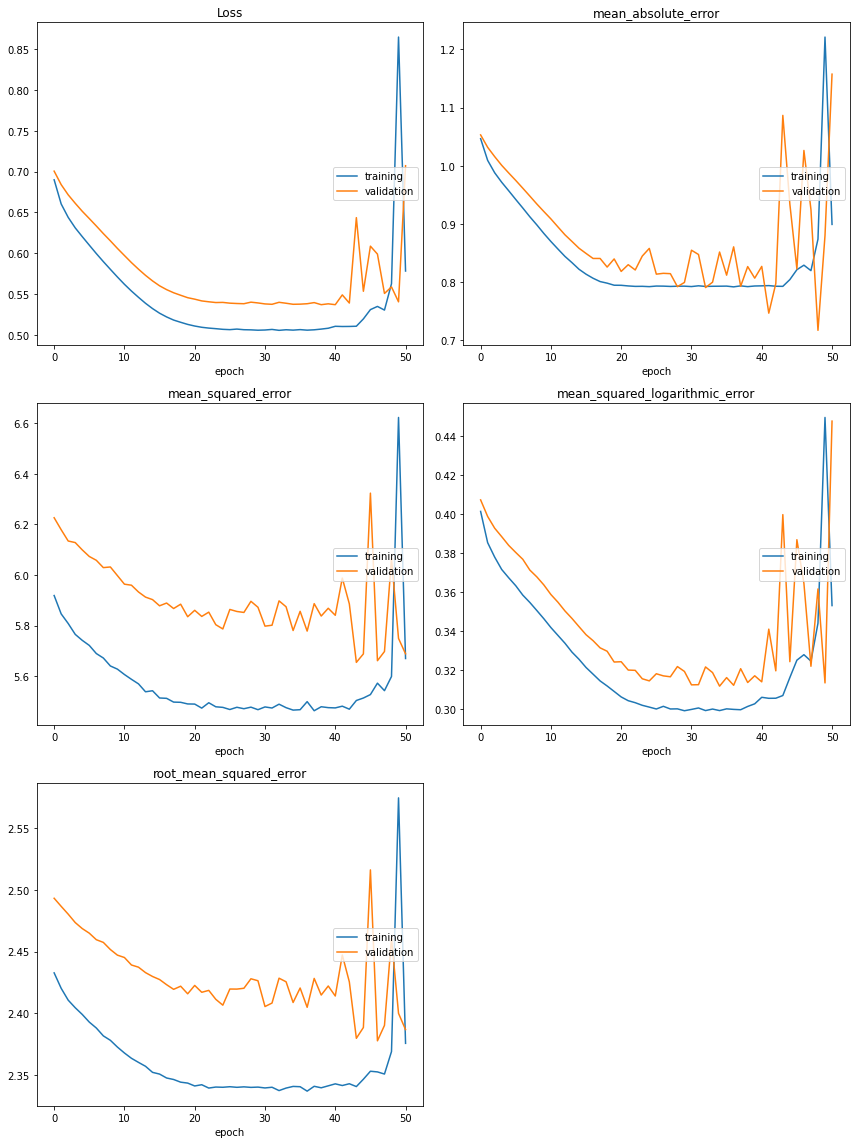

Loss
	training         	 (min:    0.506, max:    0.865, cur:    0.578)
	validation       	 (min:    0.537, max:    0.707, cur:    0.707)
mean_absolute_error
	training         	 (min:    0.792, max:    1.221, cur:    0.899)
	validation       	 (min:    0.717, max:    1.158, cur:    1.158)
mean_squared_error
	training         	 (min:    5.464, max:    6.623, cur:    5.670)
	validation       	 (min:    5.655, max:    6.324, cur:    5.689)
mean_squared_logarithmic_error
	training         	 (min:    0.299, max:    0.450, cur:    0.353)
	validation       	 (min:    0.312, max:    0.448, cur:    0.448)
root_mean_squared_error
	training         	 (min:    2.337, max:    2.574, cur:    2.376)
	validation       	 (min:    2.378, max:    2.516, cur:    2.387)
137/137 - 15s - loss: 0.5784 - mean_squared_logarithmic_error: 0.3532 - mean_squared_error: 5.6701 - mean_absolute_error: 0.8993 - root_mean_squared_error: 2.3758 - val_loss: 0.7073 - val_mean_squared_logarithmic_error: 0.4477 - val_mean_squ

In [38]:
model = tf.keras.Sequential([
    SimpleRNN(100, return_sequences=True),
    SimpleRNN(100),
    Dense(1)
])
history = compile_and_fit(model, window, should_stop=True, max_epochs=100, with_lr_schedule=True)

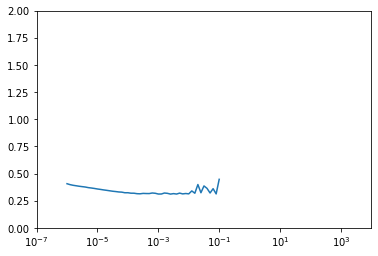

In [39]:
lr_timeline(history, [1e-7, 1e4, 0, 2]) 

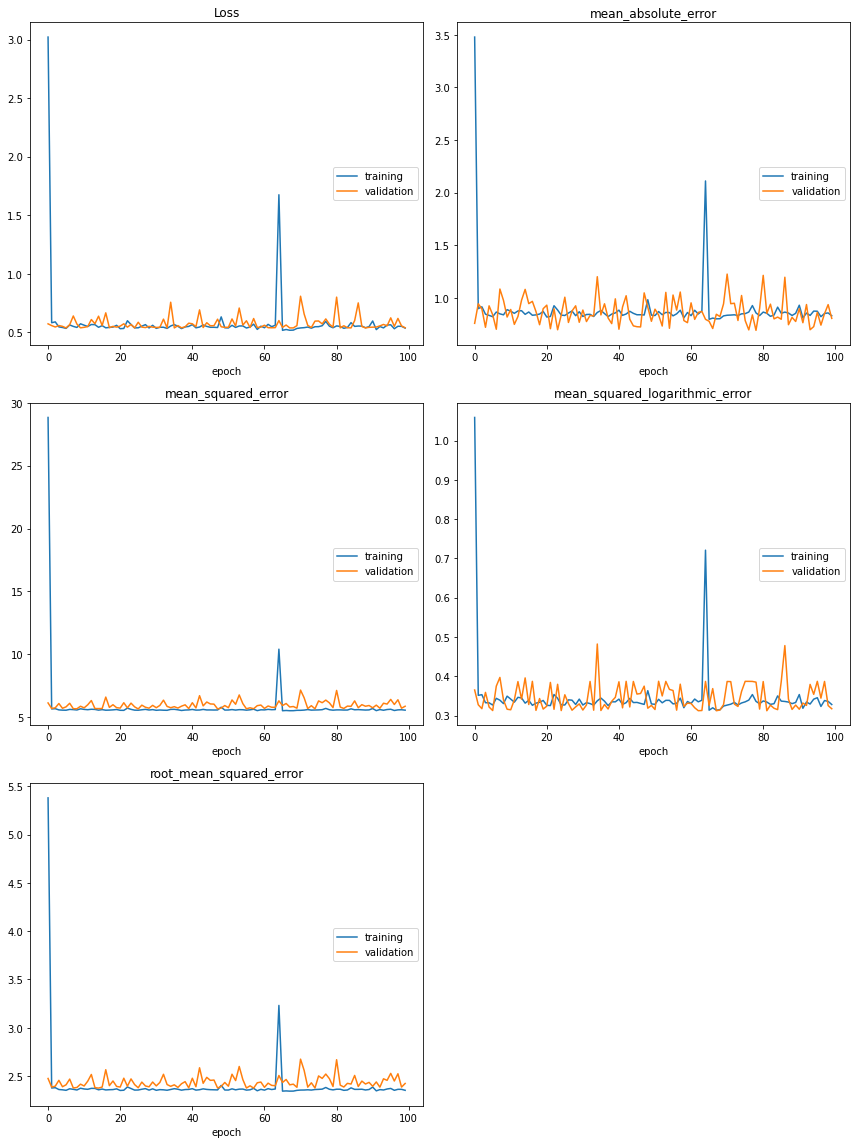

Loss
	training         	 (min:    0.517, max:    3.022, cur:    0.536)
	validation       	 (min:    0.537, max:    0.808, cur:    0.538)
mean_absolute_error
	training         	 (min:    0.797, max:    3.479, cur:    0.830)
	validation       	 (min:    0.692, max:    1.226, cur:    0.805)
mean_squared_error
	training         	 (min:    5.504, max:   28.836, cur:    5.550)
	validation       	 (min:    5.648, max:    7.147, cur:    5.861)
mean_squared_logarithmic_error
	training         	 (min:    0.314, max:    1.059, cur:    0.328)
	validation       	 (min:    0.312, max:    0.482, cur:    0.317)
root_mean_squared_error
	training         	 (min:    2.345, max:    5.380, cur:    2.353)
	validation       	 (min:    2.376, max:    2.676, cur:    2.424)
137/137 - 14s - loss: 0.5358 - mean_squared_logarithmic_error: 0.3281 - mean_squared_error: 5.5501 - mean_absolute_error: 0.8299 - root_mean_squared_error: 2.3532 - val_loss: 0.5384 - val_mean_squared_logarithmic_error: 0.3174 - val_mean_squ

In [41]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    SimpleRNN(100, return_sequences=True),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])
history = compile_and_fit(model, window, lr=0.001, should_stop=False, max_epochs=100, tensorboard=True)

In [13]:
plot_predictions(window, model, 10)

ValueError: x and y must be the same size